In [191]:
%matplotlib inline
from IPython.display import Image
import matplotlib

## Generate DAG and test out PCalg

![Dag](img/dag-pearl.png)

In [169]:
import numpy as np 
import pandas as pd
SAMPLE_SIZE = 10000

z1 = np.random.normal(0, 1, SAMPLE_SIZE)
z2 = np.random.uniform(0, 1, SAMPLE_SIZE)
z3 = z1*z2 + np.random.normal(0, 1, SAMPLE_SIZE)

w1 = z1**2 + np.random.normal(0, 1, SAMPLE_SIZE)
w2 = 3 * z2 + np.random.standard_cauchy(SAMPLE_SIZE)

x = w1 * z3 + np.random.lognormal(0, 1, SAMPLE_SIZE)
w3 = x + x**3 + np.random.normal(0, 1, SAMPLE_SIZE)
y = w3 * z3 + w2 + np.random.normal(0, 1, SAMPLE_SIZE)


features = ['z1', 'z2', 'z3',
       'w1', 'w2', 'w3',
        'x', 'y']

data = np.stack([z1,z2,z3,w1,w2,w3,x,y], axis=1)

# Utils

In [192]:
import numpy as np
import functools

def check_dataset(dataset):
    assert isinstance(dataset, np.ndarray),(
        'Dataset must be a 2D numpy array')
    assert dataset.shape[1] >= 2,(
        'Need at leat 2 variables: shape is {}'.format(dataset.shape))

def get_features(dataset, feature_names=None):
    if feature_names:
        len_condition = len(feature_names) == dataset.shape[1]
        assert isinstance(feature_names, list) and len_condition,\
            "number of elements in feature_names\
        and number of features in dataset do not match"
        return {k: v for k, v in enumerate(feature_names)}

    return {k: v for k, v in enumerate(range(dataset.shape[1]))}


def trackcalls(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        wrapper.has_been_called = True
        return func(*args, **kwargs)
    wrapper.has_been_called = False
    return wrapper


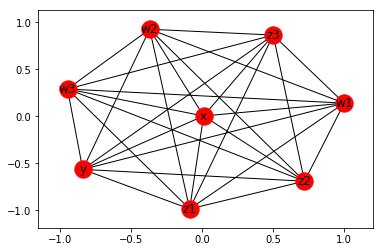

In [193]:
pc = pcalg(data, features)
pc._instantiate_fully_connected_graph()
pc.render_graph()

# PCAlg

In [189]:
import numpy as np
#from .utils import check_dataset, get_features, trackcalls
import networkx as nx
from itertools import combinations, permutations
from collections import defaultdict


class pcalg():
    """
    Peter Sprites and Clark Glymour algorithm

    input :
    dataset =  N*M numpy array where N is the sample
            size and M the feature size

    feature_names = dictionary where key = column
                    position and value = column name.
                    if no feature_names provided,
                    key=value=column position


    """

    def __init__(self, dataset, feature_names=None):
        check_dataset(dataset)
        self.dataset = dataset
        self.features = get_features(dataset,
                                     feature_names)
        self.G = nx.Graph()

    def _instantiate_fully_connected_graph(self):
        self.G.add_nodes_from(self.features.keys())
        for x, y in combinations(self.features.keys(), 2):
            self.G.add_edge(x, y)

    @trackcalls
    def identify_skeleton(self, indep_test, alpha=0.05,
                          stable=False):
        """
        STEP 1 of PC algorighm
        estimate skeleton graph from the data.
        input :
        indep_test = independence function

        alpha = significance level for independence test
                default value is 0.05

        stable = use the SGS variant of the PC algorithm
                default value is false

        """
        self._istantiate_fully_connected_graph()
        self.d_separators = {}
        d = 0
        cont = True

        while cont:
            print("Level order: {}".format(d))
            cont = False
            # in the stable version,
            # only update neighbors at each level
            x_neighbors = list(self.G.neighbors(x))
            for x, y in permutations(self.features.keys(), 2):
                if not stable:
                    # in the original version, update neighbors within
                    # each level
                    x_neighbors = list(self.G.neighbors(x))
                if y not in x_neighbors:
                    continue
                x_neighbors.remove(y)
                if len(x_neighbors) >= d:
                    cont = True
                    for z in combinations(x_neighbors, d):
                        pvalue =  indep_test(self.dataset[x],
                                    self.dataset[y],
                                    self.dataset[z])
                        if pvalue < alpha:
                            self.G.remove_edge(x, y)
                            self.d_separators[(x, y)] = z
                            self.d_separators[(y, x)] = z
                            break
            d += 1

    def orient_graph(self, indep_test, alpha):
        """
        STEP 2 of the PC algorithm: edge orientation
        """
        self.G = self.G.to_directed()

        # STEP 1: IDENTIFYING UNSHIELDED COLLIDERS
        # for each X and Y, only connected through
        # a third variable (e.g. Z in X--Z--Y), test idenpendence
        # between X and Y conditioned upon Z.
        # If conditionally dependent, Z is an unshielded collider.
        # Orient edges to point into Z (X->Z<-Y)
        # is the conditional Independence test needed???
        for x, y in combinations(self.features.keys(), 2):
            x_successors = self.G.successors(x)
            if y in x_successors:
                continue
            y_successors = self.G.successors(y)
            if x in y_successors:
                continue
            intersect = set(x_successors).intersection(set(y_successors))
            for z in intersect:
                pass

        # STEP 2: PREVENT SPURIOUS UNSHIELDED COLLIDERS
        # for each X Z Y such that
        # X->Z--Y
        # and where X and Y are not directly connected,
        # orient the ZY edge to point into Y:
        # X->Z->Y
        # if  X->Z<-Y were true, Z would have been picked up
        # as unshielded collider in STEP 1

        #  STEP 3: PREVENT CYCLES
        # If there is a pair of variables, X and Y connected 
        # both by an undirected edge and by a directed path,
        # starting at X, through one or more other variables to Y,
        # orient the undirected edge as X->Y

    def render_graph(self):
        nx.draw_networkx(G=self.G, labels=self.features)

    def save_class(self):
        return
